# Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import optuna

# Import ML models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Load file

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [3]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


# Define feature and target columns

In [6]:
# Define feature columns and target
X = train.drop(columns=['id', 'loan_status'])
y = train['loan_status']
X_test = test.drop(columns=['id'])

# Train test split

In [7]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2024)

# Feature Engineering

In [8]:
# Custom function to create new features
def feature_engineering(df):
    # Log transformation
    df['log_person_income'] = np.log1p(df['person_income'])
    df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
    
    # Debt-to-Income ratio
    df['dti_ratio'] = df['loan_amnt'] / df['person_income']
    
#     # Employment categories
#     df['employment_category'] = pd.cut(df['person_emp_length'], 
#                                         bins=[-1, 2, 5, 10, 20], 
#                                         labels=['Short-term', 'Medium-term', 'Long-term', 'Very long-term'])
    
#     # Credit history and default indicator
#     df['short_credit_history'] = (df['cb_person_cred_hist_length'] < 5).astype(int)
#     df['default_history'] = (df['cb_person_default_on_file'] == 'Y').astype(int)
    
    # Risk indicators
    df['high_interest'] = (df['loan_int_rate'] > 12).astype(int)
    df['high_loan_percent_income'] = (df['loan_percent_income'] > 0.3).astype(int)
    
    return df

In [9]:
# Define custom transformer for feature engineering
feature_engineer = FunctionTransformer(feature_engineering)

In [10]:
# Updated numerical and categorical columns
numerical_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length',
                  'log_person_income', 'log_loan_amnt', 'dti_ratio']
categorical_cols = ['person_home_ownership', 
                    'loan_intent', 
                    'loan_grade', 
#                     'employment_category'
                   ]

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Models and Hyperparameter tuning

In [11]:
# Initialize leaderboard to store the top 5 models for each type
leaderboard = {
    'xgboost': [],
    'catboost': [],
    'lgbm': []
}

In [12]:
def objective(trial):
    # Define the model type to test
    model_type = trial.suggest_categorical('model_type', [
#         'xgboost', 
#         'catboost', 
        'lgbm'])
    
    # Hyperparameter definitions for each model type
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 12),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
        }
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    elif model_type == 'catboost':
        params = {
            'iterations': trial.suggest_int('cat_iterations', 100, 2000),
            'depth': trial.suggest_int('cat_depth', 3, 12),
            'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.3),
            'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 1.0, 15.0)
        }
        model = CatBoostClassifier(**params, verbose=0, random_state=42)
    
    elif model_type == 'lgbm':
        params = {
                    'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 2000),
                    'num_leaves': trial.suggest_int('lgb_num_leaves', 31, 256),
                    'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
                    'min_child_samples': trial.suggest_int('lgb_min_child_samples', 10, 100),
                    # Additional parameters for fine-tuning
                    'max_depth': trial.suggest_int('lgb_max_depth', -1, 20),  # Maximum depth of the tree; -1 means no limit
                    'min_split_gain': trial.suggest_float('lgb_min_split_gain', 0.0, 5.0),  # Minimum gain required for a split
                    'reg_alpha': trial.suggest_float('lgb_reg_alpha', 0.0, 10.0),  # L1 regularization term
                    'reg_lambda': trial.suggest_float('lgb_reg_lambda', 0.0, 10.0),  # L2 regularization term
                    'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.6, 1.0),  # Subsample ratio of columns when constructing each tree
                    'subsample': trial.suggest_float('lgb_subsample', 0.6, 1.0),  # Subsample ratio of training instances
                    'subsample_freq': trial.suggest_int('lgb_subsample_freq', 1, 10),  # Frequency of subsample
                    'min_child_weight': trial.suggest_float('lgb_min_child_weight', 1e-3, 10.0),  # Minimum sum of instance weight (hessian) needed in a child
                    'max_bin': trial.suggest_int('lgb_max_bin', 100, 500),  # Maximum number of bins used for discretizing continuous features
                }
        model = LGBMClassifier(**params, verbosity=-1, random_state=42)
    
    # Final pipeline
    pipeline = Pipeline(steps=[
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train and evaluate the model
    pipeline.fit(X_train, y_train)
    val_preds = pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    
    # Update leaderboard for the model type
    leaderboard[model_type].append((auc, model))
    leaderboard[model_type] = sorted(leaderboard[model_type], key=lambda x: x[0], reverse=True)[:20]  # Keep top 20
    
    return auc

In [13]:
# Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # Increase trials for better results

[I 2024-10-27 06:56:49,880] A new study created in memory with name: no-name-1f96f31f-cc8f-465b-bf9f-f26ee909eb5e
[I 2024-10-27 06:56:53,578] Trial 0 finished with value: 0.9335320411964618 and parameters: {'model_type': 'lgbm', 'lgb_n_estimators': 1310, 'lgb_num_leaves': 255, 'lgb_learning_rate': 0.15958874583448812, 'lgb_min_child_samples': 62, 'lgb_max_depth': 1, 'lgb_min_split_gain': 1.2066555975598452, 'lgb_reg_alpha': 1.1752041873182673, 'lgb_reg_lambda': 9.045043904520968, 'lgb_colsample_bytree': 0.7144650975328034, 'lgb_subsample': 0.8726070006940102, 'lgb_subsample_freq': 10, 'lgb_min_child_weight': 7.666703990416504, 'lgb_max_bin': 497}. Best is trial 0 with value: 0.9335320411964618.
[I 2024-10-27 06:56:55,448] Trial 1 finished with value: 0.9510378884342856 and parameters: {'model_type': 'lgbm', 'lgb_n_estimators': 673, 'lgb_num_leaves': 211, 'lgb_learning_rate': 0.22496846670455414, 'lgb_min_child_samples': 70, 'lgb_max_depth': 14, 'lgb_min_split_gain': 2.6660539295842667,

In [14]:
# Collect top models from the leaderboard
top_models = []
for model_type, models in leaderboard.items():
    for auc, model in models:
        top_models.append({'Model Type': model_type, 'AUC-ROC': auc, 'Model': model})

# Sort the top models by AUC-ROC and select the best 20
top_models = sorted(top_models, key=lambda x: x['AUC-ROC'], reverse=True)[:20]

# Create a DataFrame to display the top models
top_models_df = pd.DataFrame(top_models)


In [15]:
top_models_df

,Model Type,AUC-ROC,Model
0,lgbm,0.962984,LGBMClassifier(colsample_bytree=0.939636015610...
1,lgbm,0.962920,LGBMClassifier(colsample_bytree=0.971806272299...
2,lgbm,0.962806,LGBMClassifier(colsample_bytree=0.857102252954...
3,lgbm,0.962688,LGBMClassifier(colsample_bytree=0.907067438848...
4,lgbm,0.962538,LGBMClassifier(colsample_bytree=0.938809379486...
5,lgbm,0.962495,LGBMClassifier(colsample_bytree=0.976333730694...
6,lgbm,0.962492,LGBMClassifier(colsample_bytree=0.984040893806...
7,lgbm,0.962486,LGBMClassifier(colsample_bytree=0.939782180461...
8,lgbm,0.962471,LGBMClassifier(colsample_bytree=0.949424481647...
9,lgbm,0.962461,LGBMClassifier(colsample_bytree=0.999597408503...


# Ensemble score

In [16]:
# Wrap each model in a pipeline with preprocessing
ensemble_estimators = [
    (f'model_{i}', Pipeline(steps=[
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', model['Model'])
    ]))
    for i, model in enumerate(top_models)
]

# Create the VotingClassifier ensemble with the preprocessed pipelines
ensemble = VotingClassifier(estimators=ensemble_estimators, voting='soft')

# Train the final ensemble on the full training data
ensemble.fit(X_train, y_train)

# Evaluate the ensemble on the validation set
ensemble_val_preds = ensemble.predict_proba(X_val)[:, 1]
ensemble_auc = roc_auc_score(y_val, ensemble_val_preds)

print(f"Ensemble AUC-ROC: {ensemble_auc}")

Ensemble AUC-ROC: 0.9630743880565741


# Ensemble on full original train set

In [17]:
# Train the final ensemble on the full training data
ensemble.fit(X, y)

VotingClassifier(estimators=[('model_0',
                              Pipeline(steps=[('feature_engineering',
                                               FunctionTransformer(func=<function feature_engineering at 0x7f3297e9f520>)),
                                              ('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['person_age',
                                                                                 'person_income',
                                                                                 'loan_amnt',
                                                                                 'loan_int_rate',
                                                                                 'cb_person_cred_hist_length',
                                                                                 'log_person_income',
                                                                                 'log_loan_amnt',
                                                                                 'dt...
                                               LGBMClassifier(colsample_bytree=0.8095991217977915,
                                                              learning_rate=0.05559934899528947,
                                                              max_bin=466,
                                                              max_depth=17,
                                                              min_child_samples=44,
                                                              min_child_weight=8.26375026944755,
                                                              min_split_gain=0.9299326992059631,
                                                              n_estimators=784,
                                                              random_state=42,
                                                              reg_alpha=0.6356360579137897,
                                                              reg_lambda=1.6333010588834445,
                                                              subsample=0.815967381061376,
                                                              subsample_freq=2,
                                                              verbosity=-1))]))],
                 voting='soft')

In [18]:
# Predict on the test set
test_preds = ensemble.predict_proba(test)[:, 1]

# Submission

In [19]:
# Prepare submission file
submission['loan_status'] = test_preds

In [20]:
submission.head()

,id,loan_status
0,58645,0.995764
1,58646,0.010182
2,58647,0.929235
3,58648,0.009929
4,58649,0.073783


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


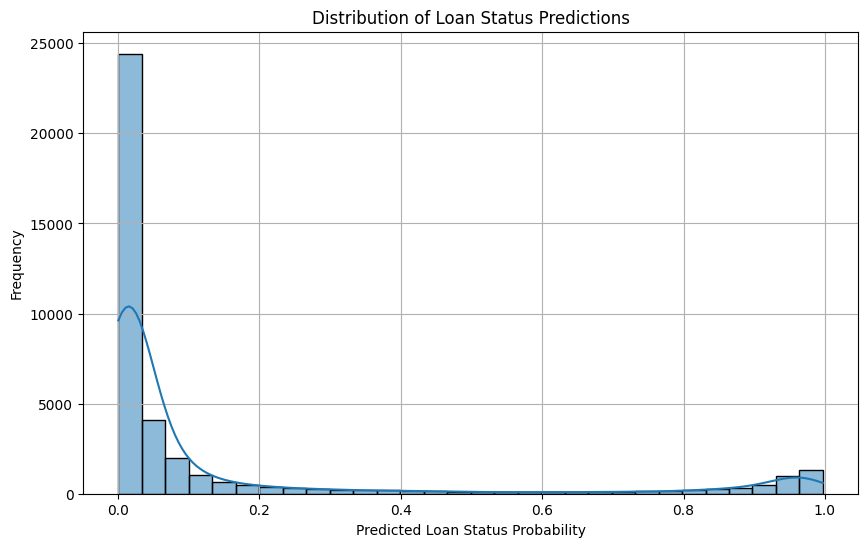

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the predictions
plt.figure(figsize=(10, 6))
sns.histplot(submission['loan_status'], bins=30, kde=True)
plt.title('Distribution of Loan Status Predictions')
plt.xlabel('Predicted Loan Status Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:
submission.to_csv('submission.csv', index=False)